### Imports & setup

In [2]:
from hydra import initialize, compose
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import os
import pickle
from pathlib import Path
import rootutils
from scipy.spatial.distance import squareform
import seaborn as sns
import torch
# from torchvision import transforms

ROOT = rootutils.setup_root(".", indicator=".project-root", pythonpath=True)

from src.analysis import cka, rsa
from rsa import get_rsa_matrix
from src.analysis.representations import (
    get_average_class_representations, 
    get_class_representations,
    compute_multimodal_cka_and_kernel_matrices
)
from src.data.data_module import MyDataModule
from src.model.model_module import LitMML, MLMWrapper
from src.model.utils import get_model_and_processor
from src.utils.utils import save_as_pickle

In [3]:
dataset_name = "CIFAR10"
checkpoints = "full_dataset_aug_mlm"
which_layer = "encoder" #"projection"

device = "cuda:1"

CKPT_DIR = Path("/home/data/bhavin/0.1_and_0.5_ckpts")
CKPT_CONFIG_DIR = os.path.join(ROOT, "configs/checkpoints")
SAVE_DATA_DIR = os.path.join(ROOT, "data", "representations")
SAVE_FIGURES_DIR = os.path.join(ROOT, "plots")
cfg_checkpoints = OmegaConf.load(os.path.join(CKPT_CONFIG_DIR, f"{checkpoints}.yaml"))

In [4]:
# Load config
cfg_path = "../../configs"

overrides = [f"checkpoints={checkpoints}",
             f"data.datasets=[{dataset_name}]",
            ]

with initialize(version_base=None, config_path=cfg_path):
    cfg = compose(config_name="rsa.yaml", overrides=overrides)
    #config = compose(overrides=[f"data.datasets=[f{DATASET}]"])
print(cfg)

{'model': {'model': {'image_encoder_name': 'google/vit-base-patch16-224', 'text_encoder_name': 'google-bert/bert-base-uncased', 'tokenizer': {'use_fast': False}}}, 'data': {'datasets': ['CIFAR10'], 'dataloader': {'coco_val': {'batch_size': 128, 'shuffle': False}, 'test': {'batch_size': 128, 'shuffle': False, 'num_workers': 8, 'pin_memory': True}}, 'root': '${paths.data_dir}', 'Places365': {'root': '/home/data/places365/'}, 'use_subset_probe': {'value': False, 'subset_fraction': 0.1}, 'dataset': {'val': ['coco_val_dummy'], 'transforms': {'enabled': True, 'RandAugment': {'num_ops': 3, 'magnitude': 8}}, 'max_seq_length': 72, 'coco': {'root': '/home/data/mscoco_captions/', 'split_train': '/home/phisch/multimodal/my_datasets/coco_karpathy_train.json', 'split_val': '${paths.root_dir}src/data/datasets/coco_karpathy_val.json', 'split_test': '/home/phisch/multimodal/my_datasets/coco_karpathy_test.json'}, 'vg': {'data_dir': '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/shared/datasets/VG_Bhavin/VG'}, 

### Workflow
1. Get model representations for each class of a dataset (average class representation)
2. Compute RDM by measuring (dis-)similarites of class representations
3. Compute RSA by measuring (dis-)similarities of RDMs

### Get model representations
1. Load model & dataset
2. Compute representations and calculate average class representations
3. Store average class representations

## Load model & dataset

In [5]:
# Load model
model, processor = get_model_and_processor(cfg.model)
model = MLMWrapper(model)

In [6]:
# Load dataset
data_module = MyDataModule(
    cfg.data,
    processor,
)
all_test_dataloaders = data_module.get_test_dataloaders()
dataloader = all_test_dataloaders[dataset_name]["test"]
num_classes = dataloader.dataset.num_classes
class_names = dataloader.dataset.classnames
print(num_classes)
print(class_names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Classnames: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
Template: no template
Embed classnames, compute representation
1. Tokenize -> processor
2. forward through model -> rep of every classname
3. classname representations: (num_classes, embed_dim)

In [6]:
# Create classname embeddings
templates = cfg.data.dataset.caption_template
# templates = ["a photo of a {}.", "a picture of a {}."]
if isinstance(templates, str):
    templates = [templates]
print(templates)
texts = [template.format(classname) for template in templates for classname in class_names] #TODO: enable multiple templates
text_embeds = processor(text=texts, return_tensors="pt", padding=True, truncation=True)

['{}']


In [ ]:
a = torch.rand(10, 512)
print(a.size())
print(a[0, :].size())
b = torch.stack([a[0, :] for _ in range(10)], dim=0)
print(b.size())
c = (
        torch.cat([torch.stack([a[x, :] for _ in range(10)], dim=0) 
                           for x in range(a.size(0))], axis=0)
    )
print(c.size())

torch.Size([10, 512])
torch.Size([512])
torch.Size([10, 512])
torch.Size([100, 512])
tensor([[0.0557, 0.7499, 0.7710,  ..., 0.3103, 0.6545, 0.2735],
        [0.0557, 0.7499, 0.7710,  ..., 0.3103, 0.6545, 0.2735],
        [0.0557, 0.7499, 0.7710,  ..., 0.3103, 0.6545, 0.2735],
        ...,
        [0.6476, 0.2019, 0.4282,  ..., 0.0726, 0.2397, 0.1186],
        [0.6476, 0.2019, 0.4282,  ..., 0.0726, 0.2397, 0.1186],
        [0.6476, 0.2019, 0.4282,  ..., 0.0726, 0.2397, 0.1186]])


In [34]:
print(f"Computing class representations for checkpoints {checkpoints}")

save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

model_reps_img = dict()
model_reps_txt = dict()
num_examples_per_class = 1000

for ckpt in cfg_checkpoints:
    model_name = cfg_checkpoints[ckpt]["model"]
    ckpt_path = cfg_checkpoints[ckpt]["path"]
    # files = os.listdir(os.path.join(CKPT_DIR, ckpt))
    # if "last.ckpt" in files:
    #     files.remove("last.ckpt")
    # ckpt_path = os.path.join(CKPT_DIR, ckpt, files[0])
    
    # Load checkpoint
    print(f"Loading model {ckpt}:{model_name} from checkpoint", ckpt_path)    
    lit_model = LitMML.load_from_checkpoint(ckpt_path, model=model, processor=processor, map_location=device)
    model, processor = lit_model.model, lit_model.processor
    vision_forward_func = lambda x: model.get_image_features(pixel_values=x)
    # text_forward_func = lambda x, y: model.get_text_features(input_ids=x, attention_mask=y)
    # del lit_model
    # torch.cuda.empty_cache()
    
    print("Computing class representations")
    class_representations_texts = model.get_text_features(**text_embeds.to(device)).detach()
    stacked_cls_reps_texts = (
        torch.cat([torch.stack([class_representations_texts[x, :] for _ in range(num_examples_per_class)], dim=0) 
                           for x in range(class_representations_texts.size(0))], axis=0)
        .cpu()
        .numpy()
    )
    model_reps_txt[ckpt] = stacked_cls_reps_texts
    
    class_representations_image = get_class_representations(dataloader,
                                                      vision_forward_func,
                                                      num_classes,
                                                      device,
                                                      )
    # avg_class_representations = get_average_class_representations(class_representations_image)
    stacked_cls_reps_img = (
        torch.concatenate([torch.stack(class_representations_image[x]) for x in class_representations_image], axis=0)
        .cpu()
        .numpy()
    )
    model_reps_img[ckpt] = stacked_cls_reps_img
    
    # save_file_path = os.path.join(save_file_dir, f"{dataset_name}-{ckpt}-mean_class_reps-vis_enc.pkl")
    # save_as_pickle(avg_class_representations, save_file_path)
    # print(f"Saved: {save_file_path}")
    
    # save_file_path = os.path.join(save_file_dir, f"{dataset_name}-{ckpt}-mean_class_reps-text_enc.pkl")
    # save_as_pickle(class_representations_texts, save_file_path)
    # print(f"Saved: {save_file_path}")


Computing class representations for checkpoints full_dataset_aug_mlm
Loading model 3burj4np:CLIP from checkpoint /home/data/bhavin/higher_augmentations_ckpts/3burj4np/last.ckpt


/home/phisch/venv_py3.8/py3.8/lib/python3.8/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.3, which is newer than your current Lightning version: v2.2.0.post0


Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:51<00:00,  1.42s/it]


Loading model 7m9tx2jf:CLIP + ITM from checkpoint /home/data/bhavin/higher_augmentations_ckpts/7m9tx2jf/last.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Loading model 95ddsmmz:CLIP + SimCLR from checkpoint /home/data/bhavin/higher_augmentations_ckpts/95ddsmmz/last.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Loading model ng70n4a4:CLIP + SimCLR + ITM from checkpoint /home/data/bhavin/higher_augmentations_ckpts/ng70n4a4/last.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:50<00:00,  1.39s/it]


Loading model p99godxb:SimCLR from checkpoint /home/data/bhavin/higher_augmentations_ckpts/p99godxb/last.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:50<00:00,  1.39s/it]


Loading model xpbl8wfc:SimCLR + ITM from checkpoint /home/data/bhavin/higher_augmentations_ckpts/xpbl8wfc/last.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Loading model bj2tw5qt:SimCLR + ITM + MLM from checkpoint /home/data/arena-multimodal/mlm_ckpts/bj2tw5qt/ckpt-epoch=84-loss-val=0.599.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


Loading model khb9ltyn:CLIP + ITM + MLM from checkpoint /home/data/arena-multimodal/mlm_ckpts/khb9ltyn/ckpt-epoch=49-loss-val=1.601.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:50<00:00,  1.39s/it]


Loading model mkqp8hhx:ITM + MLM from checkpoint /home/data/arena-multimodal/mlm_ckpts/mkqp8hhx/ckpt-epoch=74-loss-val=0.885.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:50<00:00,  1.39s/it]


Loading model txva2y48:CLIP + SimCLR + MLM from checkpoint /home/data/arena-multimodal/mlm_ckpts/txva2y48/ckpt-epoch=79-loss-val=1.435.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:55<00:00,  1.47s/it]


Loading model shf56cne:CLIP + MLM from checkpoint /home/data/bhavin/shf56cne/ckpt-epoch=94-loss-val=2.031.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Loading model gtp8w6c4:SimCLR + MLM from checkpoint /home/data/bhavin/gtp8w6c4/ckpt-epoch=39-loss-val=0.851.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


Loading model tibwkymx:CLIP + ITM + SimCLR + MLM from checkpoint /home/data/bhavin/tibwkymx/ckpt-epoch=119-loss-val=1.134.ckpt
Computing class representations
(10000, 512)


Getting features...: 100%|██████████| 79/79 [09:59<00:00,  7.59s/it]


In [19]:
model_reps_img["3burj4np"].shape

(10000, 512)

In [35]:
save_file_path = os.path.join(save_file_dir, f"{dataset_name}-{checkpoints}-CKA_multimodal.pkl")
CKA_MAT, KERNEL_MAT = compute_multimodal_cka_and_kernel_matrices(model_reps_img, model_reps_txt, save_file_path, device=device)

Using CUDA for CKA computation


Computing CKA and Kernel matrices...: 100%|██████████| 13/13 [21:13<00:00, 97.99s/it]


Saved in /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-full_dataset_aug_mlm-CKA_multimodal.pkl


## CKA

In [14]:
cka_file_path = "/home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-full_dataset_aug_mlm-CKA_multimodal.pkl"
# cka_file_path = "/home/phisch/multimodal/data/representations/CIFAR10/full_dataset/CIFAR10-cka_and_kernel_matrices-vis_enc.pkl"
with open(cka_file_path, "rb") as f:
    cka_data = pickle.load(f)
cka_data

EOFError: Ran out of input

In [ ]:
from pathlib import Path
import seaborn as sns
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.manifold import TSNE
from utils import load_cka_results
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-dark")

MODEL_NAMES = ["SimCLR", "SimCLR + ITM", "CLIP + SimCLR", "CLIP + SimCLR + ITM", "CLIP + ITM", "CLIP"]
dataset_name = "CIFAR100"

cka_all_splits = load_cka_results(Path("/home/phisch/multimodal/data") / dataset_name)
key_order = ["0.2_dataset", "0.4_dataset", "0.6_dataset", "0.8_dataset", "full_dataset", "full_dataset_im384"]
sorted_cka_all_splits = {key: cka_all_splits[key] for key in key_order if key in cka_all_splits}
cka_all_splits = sorted_cka_all_splits

num_splits = 1 #len(cka_all_splits)
num_measures = 2
labels = MODEL_NAMES

fig, axs = plt.subplots(ncols=num_measures,
                        nrows=num_splits, 
                        figsize=(4 * num_measures, 5 * num_splits)
                        )
# fig.subplots_adjust(wspace=0.5, hspace=1.0)
fig.suptitle(f"CKA for {dataset_name}", y=0.92, fontsize=16, fontweight="bold")

axs[0, 0].set_title("Linear", color="black", y=0.5, fontsize=16, labelpad=20, fontweight='bold')
axs[0, 1].set_title("Kernel", color="black", y=0.5, fontsize=16, labelpad=20, fontweight='bold')
axs[0, 0].set_yticks([x for x in range(6)], MODEL_NAMES)
axs[1, 0].set_yticks([x for x in range(6)], MODEL_NAMES)

for split_idx, split in enumerate(cka_all_splits):
    axs[0, split_idx].set_title(split, color="black", y=1.1, fontsize=14, fontweight='bold')
    for sind, rsa_matrix in enumerate(cka_all_splits[split].values()):
        ax = axs[sind, split_idx]
        img = ax.imshow(rsa_matrix, cmap=sns.color_palette("flare", as_cmap=True))
        ax.set_xticks([x for x in range(6)], MODEL_NAMES, rotation=90)

fig.colorbar(img, ax=axs, fraction=0.04)#, pad=0.1)
# fig.tight_layout()

## RDM

### Uni-modal RDM

In [6]:
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

mean_class_representations = {}
for ckpt in cfg_checkpoints:
    file_name = f"{dataset_name}-{ckpt}-mean_class_reps-text_enc.pkl"
    file_path = os.path.join(save_file_dir, file_name)
    print(f"Loading mean class representations from {file_path}")
    with open(file_path, "rb") as f:
        mean_class_representations[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-text_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-text_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-text_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-ng70n4a4-mean_class_reps-text_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-p99godxb-mean_class_reps-text_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-xpbl8wfc-mean_class_reps-text_enc.pkl
Loading mean class representations from 

/tmp/ipykernel_2766465/3874221533.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


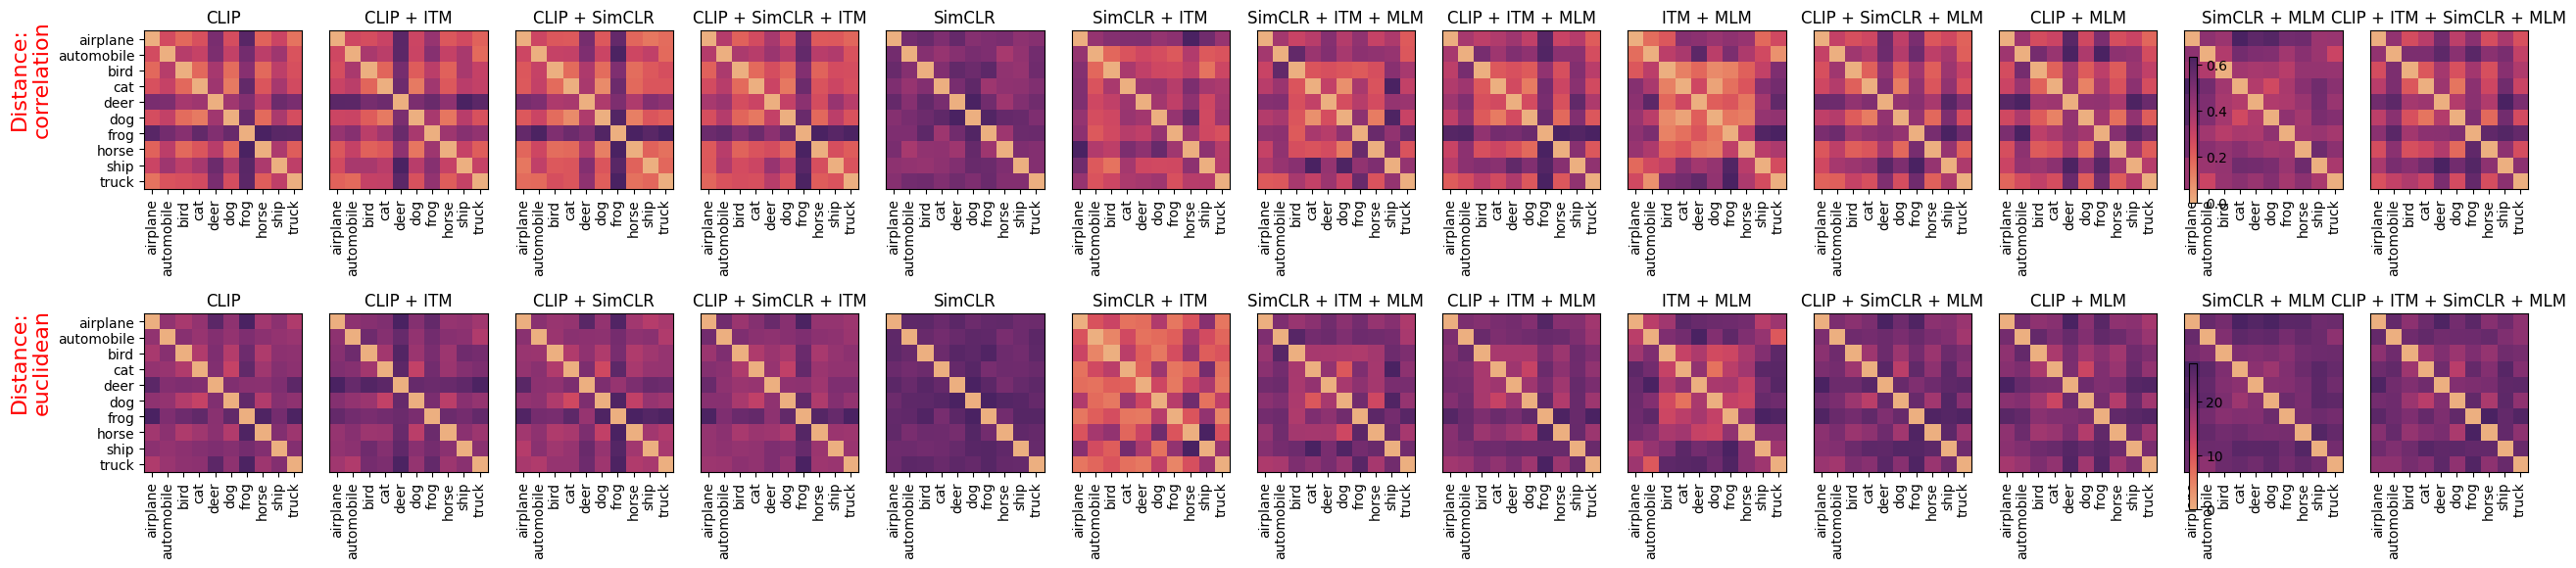

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# plt.style.use("seaborn-v0_8-")

METRICS_FOR_RDMS = [
    "correlation",
    "euclidean",
]

fig, axs = plt.subplots(
    len(METRICS_FOR_RDMS), len(mean_class_representations), 
    figsize=(2 * len(mean_class_representations), 3 * len(METRICS_FOR_RDMS))
)
fig.subplots_adjust(hspace=1.1, wspace=0.5)  # Adjust spacing between subplots

for method_idx, method in enumerate(METRICS_FOR_RDMS):
    axs[method_idx, 0].set_ylabel(f"Distance:\n{method}", color="red", y=0.7, fontsize=16)
    axs[method_idx, 0].set_yticks(
        [x for x in range(num_classes)], class_names
    )
    for ax in axs[method_idx, 1:]:
        ax.set_yticks([])

    # Collect all heatmaps in a row for a single colorbar
    imgs = []
    for model_idx, model in enumerate(mean_class_representations):
        representations = mean_class_representations[model]
        a = rsa.get_rdm(representations, metric=method)
        img = axs[method_idx, model_idx].imshow(
            squareform(a), cmap=sns.color_palette("flare", as_cmap=True)
        )
        imgs.append(img)
        axs[method_idx, model_idx].set_title(cfg_checkpoints[model]["model"])
        axs[method_idx, model_idx].set_xticks(
            [x for x in range(num_classes)],
            class_names,
            rotation=90,
        )

    # Add a single colorbar for the row
    cbar = fig.colorbar(
        imgs[-1], ax=axs[method_idx, :], location='right', fraction=0.05, pad=0.1
    )
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
# plt.savefig(SAVE_FIGURES_FIG / "RDMs_all_models_last_layer.png", bbox_inches="tight")

0
13


/tmp/ipykernel_3339144/466661425.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


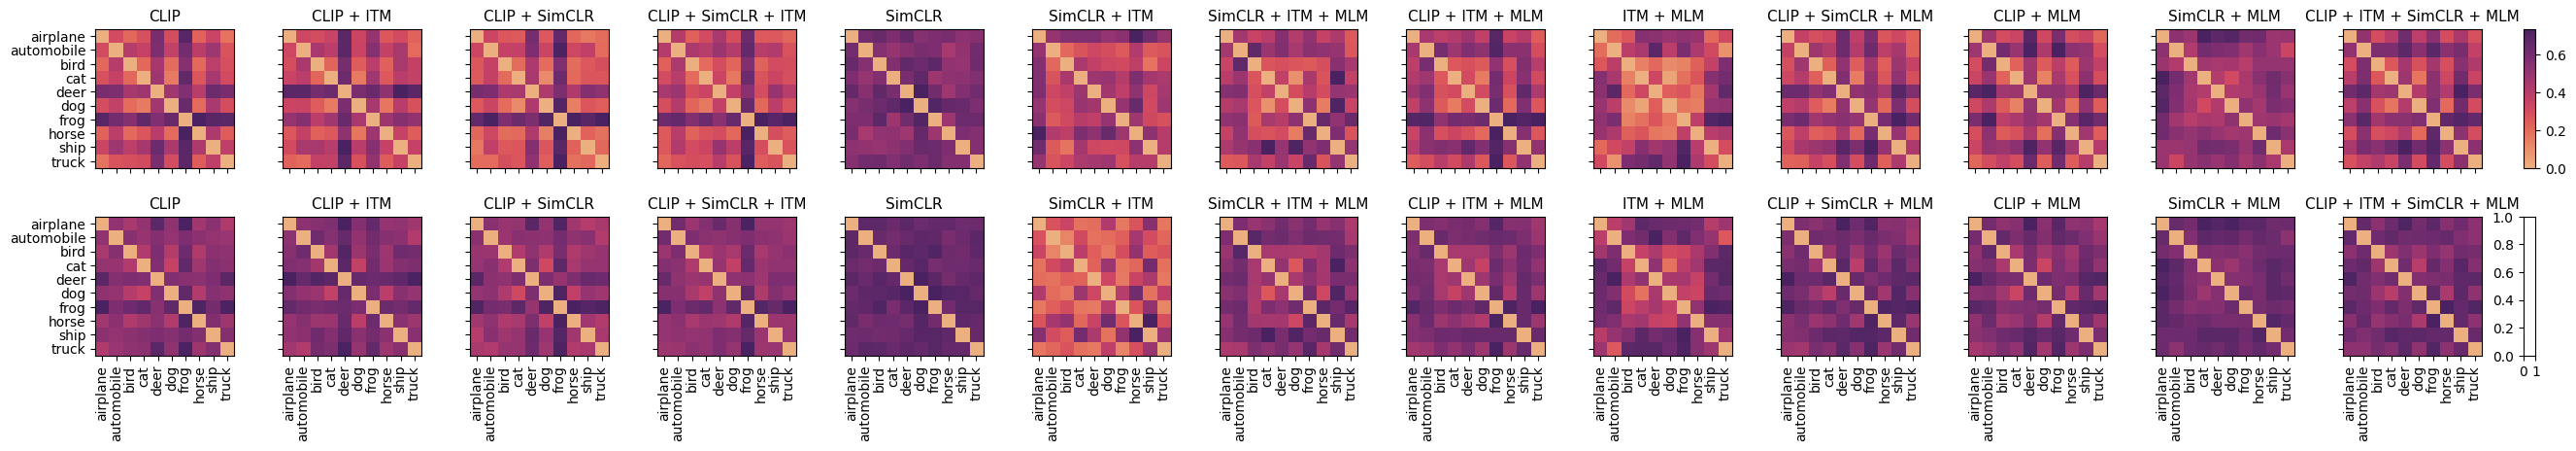

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import squareform

# plt.style.use("seaborn-v0_8-")

def demo_right_cbar(fig, nrows, ncols):
    """
    A grid of 2x2 images. Each row has its own colorbar.
    """
    grid = AxesGrid(fig, 122,  # similar to subplot(122)
                    nrows_ncols=(nrows, ncols),
                    axes_pad=0.10,
                    label_mode="L",
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="edge",
                    cbar_size="7%",
                    cbar_pad="2%",
                    )
    
    Z, extent = get_demo_image()
    cmaps = ["spring", "winter"]
    for i in range(4):
        im = grid[i].imshow(Z, extent=extent, cmap=cmaps[i//2])
        if i % 2:
            grid.cbar_axes[i//2].colorbar(im)

    for cax in grid.cbar_axes:
        cax.axis[cax.orientation].set_label('Foo')

    # This affects all Axes because we set share_all = True.
    grid.axes_llc.set_xticks([-2, 0, 2])
    grid.axes_llc.set_yticks([-2, 0, 2])


METRICS_FOR_RDMS = [
    "correlation",
    "euclidean",
]

# Create a GridSpec to manage the layout
num_rows = len(METRICS_FOR_RDMS)
num_cols = len(mean_class_representations)
fig = plt.figure(figsize=(4 * num_cols, 6 * num_rows))

grid = AxesGrid(fig, 121,  # similar to subplot(122)
                nrows_ncols=(num_rows, num_cols),
                axes_pad=0.50,
                label_mode="L",
                share_all=True,
                cbar_location="right",
                cbar_mode="edge",
                cbar_size="9%",
                cbar_pad="30%",
                )

for i in range(num_rows * num_cols):
    model_name = list(mean_class_representations.keys())[i%num_cols]
    representations = mean_class_representations[model_name]
    a = rsa.get_rdm(representations, metric=METRICS_FOR_RDMS[i//num_cols])
    img = grid[i].imshow(
        squareform(a), cmap=sns.color_palette("flare", as_cmap=True)
    )
    grid[i].set_title(cfg_checkpoints[model_name]["model"], fontsize=11)
    grid[i].set_xticks(
            [x for x in range(num_classes)],
            class_names,
            rotation=90,
        )
    grid[i].set_yticks(
        [x for x in range(num_classes)], class_names
    )
    # grid.cbar_axes[i].colorbar(img)
    if i == 0:#(num_cols-1):
        print(i)
        grid.cbar_axes[i].colorbar(img)
    if i == 13:#(2*num_cols-1):
        print(i)
        grid.cbar_axes[i].colorbar(img)
# print(grid.cbar_axes[0])
# for cax in grid.cbar_axes:
#     cax.axis[cax.orientation].set_label('Foo')

plt.tight_layout()
# plt.savefig(SAVE_FIGURES_FIG / "RDMs_all_models_last_layer.png", bbox_inches="tight")

### Multi-modal RDM

In [24]:
# Load data representations
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

mean_class_representations_img = {}
mean_class_representations_txt = {}
for ckpt in cfg_checkpoints:
    for x in ["vis", "text"]:
        file_name = f"{dataset_name}-{ckpt}-mean_class_reps-{x}_proj.pkl"
        file_path = os.path.join(save_file_dir, file_name)
        print(f"Loading mean class representations from {file_path}")
        with open(file_path, "rb") as f:
            if x == "vis":
                mean_class_representations_img[ckpt] = pickle.load(f)
            else:
                mean_class_representations_txt[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-text_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-text_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-text_proj.pkl
Loading mean class representations fr

/tmp/ipykernel_3380255/370553385.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


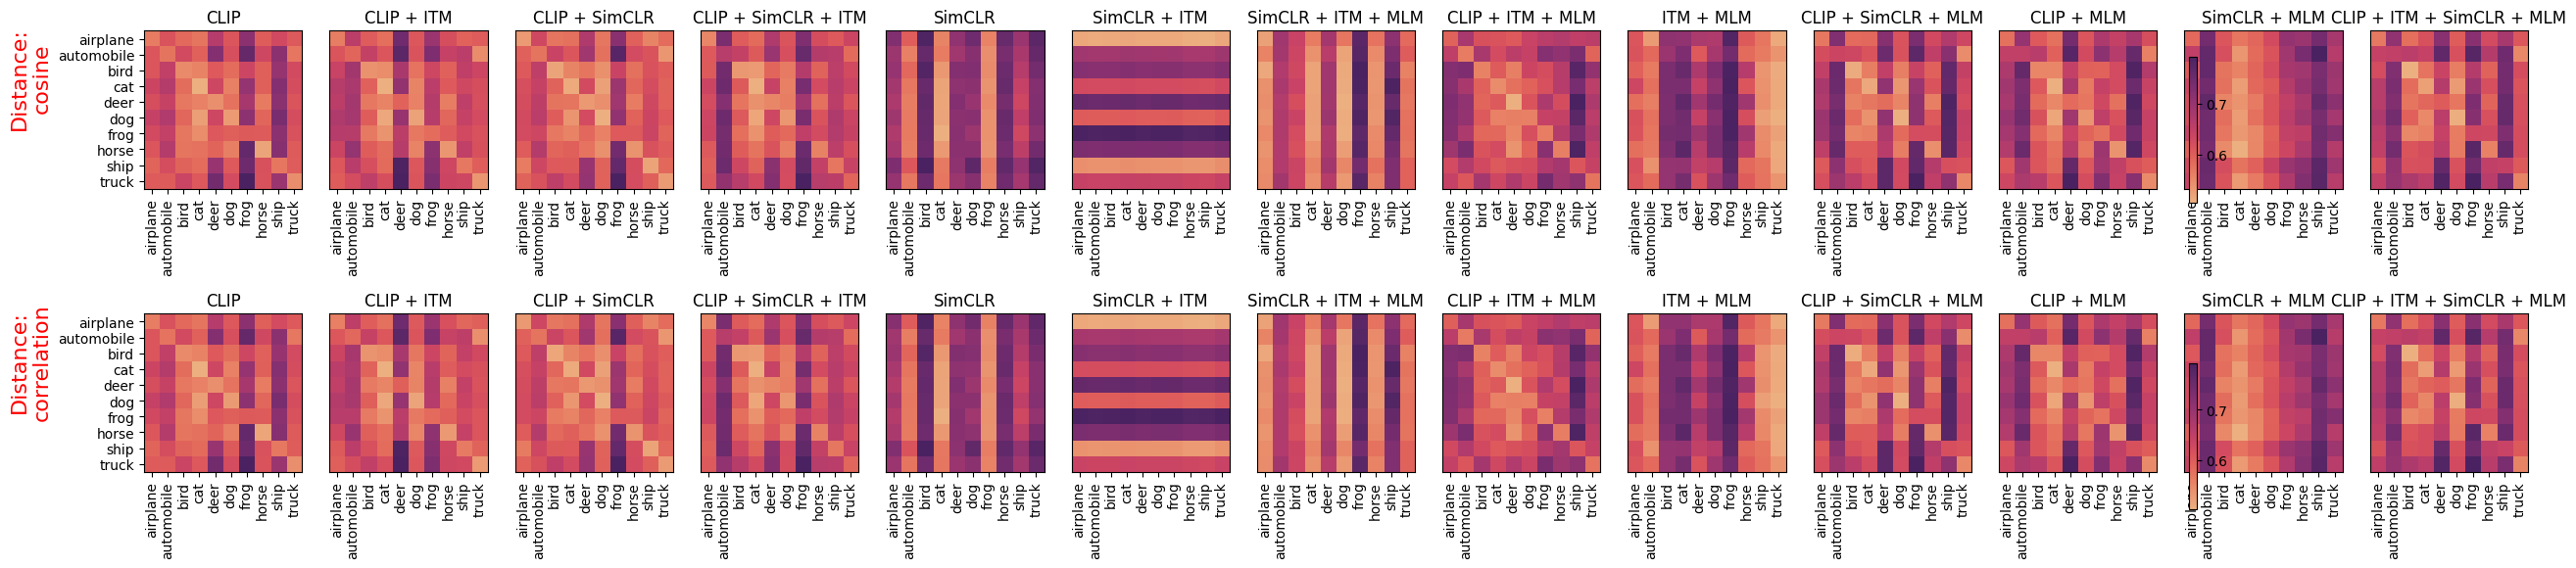

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# plt.style.use("seaborn-v0_8-")

METRICS_FOR_RDMS = [
    "cosine",
    "correlation",
    # "euclidean",
]

fig, axs = plt.subplots(
    len(METRICS_FOR_RDMS), len(mean_class_representations_img), 
    figsize=(2 * len(mean_class_representations_img), 3 * len(METRICS_FOR_RDMS))
)
fig.subplots_adjust(hspace=1.1, wspace=0.5)  # Adjust spacing between subplots

for method_idx, method in enumerate(METRICS_FOR_RDMS):
    axs[method_idx, 0].set_ylabel(f"Distance:\n{method}", color="red", y=0.7, fontsize=16)
    axs[method_idx, 0].set_yticks(
        [x for x in range(num_classes)], class_names
    )
    for ax in axs[method_idx, 1:]:
        ax.set_yticks([])

    # Collect all heatmaps in a row for a single colorbar
    imgs = []
    for model_idx, model in enumerate(mean_class_representations_img.keys()):
        representations_img = mean_class_representations_img[model]
        representations_txt = mean_class_representations_txt[model]
        a = rsa.get_multimodal_rdm(representations_img, representations_txt, metric=method)
        img = axs[method_idx, model_idx].imshow(
            # squareform(a), cmap=sns.color_palette("flare", as_cmap=True)
            a, cmap=sns.color_palette("flare", as_cmap=True)
        )
        imgs.append(img)
        axs[method_idx, model_idx].set_title(cfg_checkpoints[model]["model"])
        axs[method_idx, model_idx].set_xticks(
            [x for x in range(num_classes)],
            class_names,
            rotation=90,
        )

    # Add a single colorbar for the row
    cbar = fig.colorbar(
        imgs[-1], ax=axs[method_idx, :], location='right', fraction=0.05, pad=0.1
    )
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
# plt.savefig(SAVE_FIGURES_FIG / "RDMs_all_models_last_layer.png", bbox_inches="tight")

## RSA

### Between multi-modal RDMs

In [7]:
# Load data representations
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

mean_class_representations_img = {}
mean_class_representations_txt = {}
for ckpt in cfg_checkpoints:
    for x in ["vis", "text"]:
        file_name = f"{dataset_name}-{ckpt}-mean_class_reps-{x}_proj.pkl"
        file_path = os.path.join(save_file_dir, file_name)
        print(f"Loading mean class representations from {file_path}")
        with open(file_path, "rb") as f:
            if x == "vis":
                mean_class_representations_img[ckpt] = pickle.load(f)
            else:
                mean_class_representations_txt[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-text_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-text_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-text_proj.pkl
Loading mean class representations fr

In [19]:
similarity_measure = [
    "pearsonr",
    "spearmanr",
    # "riemann",
]

def get_rsa_matrix(reps_img, reps_txt, rsa_similarity_measure, rdm_similarity_measure="cosine"):
    assert len(reps_img) == len(reps_txt)
    rsa_matrix = np.zeros((len(reps_img), len(reps_img)))
    for i, key1 in enumerate(reps_img.keys()):
        for j, key2 in enumerate(reps_img.keys()):
            rdm_1 = rsa.get_multimodal_rdm(reps_img[key1], reps_txt[key1], metric=rdm_similarity_measure)
            rdm_2 = rsa.get_multimodal_rdm(reps_img[key2], reps_txt[key2], metric=rdm_similarity_measure)
            rdm_1 = rdm_1.flatten()
            rdm_2 = rdm_2.flatten()
            rsaval = rsa.get_rsa(rdm_1, rdm_2, similarity_measure=rsa_similarity_measure)
            # print (rsaval)
            if rsa_similarity_measure != "riemann":
                rsa_matrix[i, j] = rsaval.statistic
            else:
                rsa_matrix[i, j] = rsaval
    return rsa_matrix

# model_order = ["SimCLR", "SimCLR + ITM", "CLIP + SimCLR", "CLIP + SimCLR + ITM", "CLIP + ITM", "CLIP"]
# model_order = [ # full_dataset_mlm
#     "shf56cne", # CLIP + MLM
#     "khb9ltyn", # "CLIP + ITM + MLM"
#     "txva2y48", # "CLIP + SimCLR + MLM"
#     "tibwkymx", # "CLIP + ITM + SimCLR + MLM
#     "bj2tw5qt", # "SimCLR + ITM + MLM"
#     "gtp8w6c4", # "SimCLR + MLM"
#     "mkqp8hhx", # "ITM + MLM"
# ]
# model_order = [ # full_dataset_aug
#     "3burj4np", # CLIP
#     "7m9tx2jf", # CLIP + ITM
#     "95ddsmmz", # CLIP + SimCLR
#     "ng70n4a4", # CLIP + SimCLR + ITM
#     "xpbl8wfc", # SimCLR + ITM
#     "p99godxb", # SimCLR
# ]
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + ITM + SimCLR + MLM
    "txva2y48", # CLIP + SimCLR + MLM
    "khb9ltyn", # CLIP + ITM + MLM
    "shf56cne", # CLIP + MLM
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
mean_class_representations_img = {model: mean_class_representations_img[model] for model in model_order}
mean_class_representations_txt = {model: mean_class_representations_txt[model] for model in model_order}
# for model in model_order:

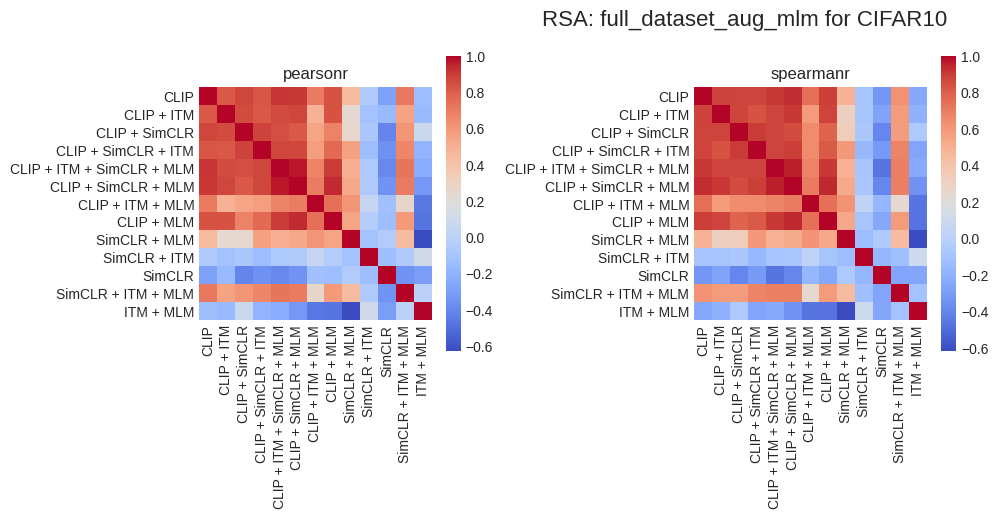

In [20]:
plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(15, 5))
plt.suptitle(f"RSA: {checkpoints} for {dataset_name}", fontsize=16)

for sind, sim in enumerate(similarity_measure):
    plt.subplot(1, 3, sind + 1)
    plt.title(sim)
    rsa_matrix = get_rsa_matrix(mean_class_representations_img, mean_class_representations_txt, rsa_similarity_measure=sim, rdm_similarity_measure="cosine")
    plt.imshow(rsa_matrix, cmap="coolwarm")
    plt.yticks(
        [x for x in range(len(mean_class_representations_img.keys()))], 
        [cfg_checkpoints[k]["model"] for k in mean_class_representations_img.keys()],
    )
    plt.xticks(
        [x for x in range(len(mean_class_representations_img.keys()))],
        [cfg_checkpoints[k]["model"] for k in mean_class_representations_img.keys()],
        rotation=90,
    )
    plt.colorbar()#fraction=0.045)

plt.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_FIGURES_DIR, f"RSA-{DATASET_SPLIT}.png"), bbox_inches="tight"
# )

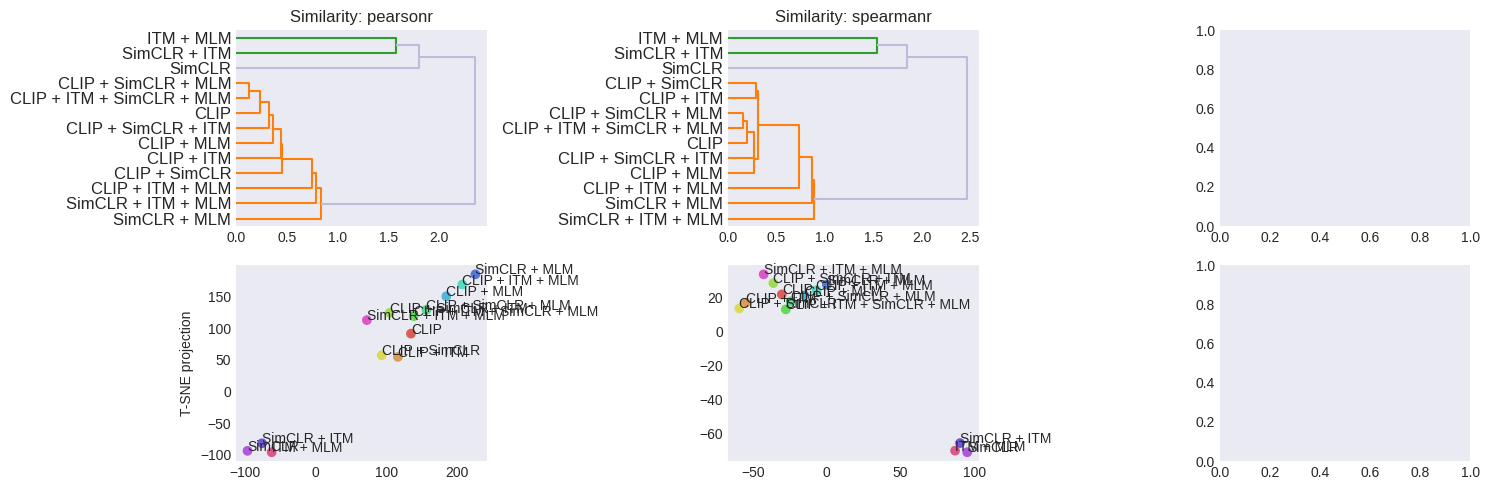

In [21]:
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.manifold import TSNE

plt.style.use("seaborn-v0_8-dark")

labels = [cfg_checkpoints[k]["model"] for k in mean_class_representations_img.keys()]
fig, axes = plt.subplots(2, 3, figsize=(15, 5), height_ratios=[1, 1])

axes[1, 0].set_ylabel("T-SNE projection")

for sind, sim in enumerate(similarity_measure):
    rsa_matrix = get_rsa_matrix(mean_class_representations_img, mean_class_representations_txt, rsa_similarity_measure=sim)
    z = hierarchy.linkage(rsa_matrix)
    dn2 = hierarchy.dendrogram(
        z,
        ax=axes[0, sind],
        above_threshold_color="#bcbddc",
        # color_threshold=1.5,
        orientation="right",
        labels=labels,
    )
    axes[0, sind].set_title(f"Similarity: {sim}")

    _perplexity = 2
    X_embedded = TSNE(
        n_components=2, learning_rate="auto", init="random", perplexity=_perplexity
    ).fit_transform(rsa_matrix)

    xs = X_embedded[:, 0]
    ys = X_embedded[:, 1]
    axes[1, sind].scatter(
        xs,
        ys,
        color=sns.color_palette("hls", 13),
    )

    xoffset = 0
    yoffset = 0
    for ind, labeltext in enumerate(labels):
        axes[1, sind].text(xs[ind] + xoffset, ys[ind] + yoffset, labeltext, rotation=0)

fig.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_FIGURES_DIR, f"RSA-tsne_dendrogram-{DATASET_SPLIT}.png"),
#     bbox_inches="tight",
# )

### Between uni-modal RDMs of different modalities (Visual RDM vs. Textual RDM)

In [11]:
# Load data representations
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

mean_class_representations_img = {}
mean_class_representations_txt = {}
for ckpt in cfg_checkpoints:
    for x in ["vis", "text"]:
        file_name = f"{dataset_name}-{ckpt}-mean_class_reps-{x}_proj.pkl"
        file_path = os.path.join(save_file_dir, file_name)
        print(f"Loading mean class representations from {file_path}")
        with open(file_path, "rb") as f:
            if x == "vis":
                mean_class_representations_img[ckpt] = pickle.load(f)
            else:
                mean_class_representations_txt[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-text_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-text_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_proj.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-text_proj.pkl
Loading mean class representations fr

In [11]:
checkpoints = "full_dataset_aug_mlm"

# Load data representations
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, "full_dataset_mlm")
save_file_dir_2 = os.path.join(SAVE_DATA_DIR, dataset_name, "full_dataset_aug")
save_file_dir_2 = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)
save_file_dir = os.path.join(SAVE_DATA_DIR, dataset_name, checkpoints)

mean_class_representations = {}
for ckpt in cfg_checkpoints:
    file_name = f"{dataset_name}-{ckpt}-mean_class_reps-vis_enc.pkl"
    if "MLM" in cfg_checkpoints[ckpt]["model"]:
        file_path = os.path.join(save_file_dir, file_name)
    else:
        file_path = os.path.join(save_file_dir_2, file_name)
    print(f"Loading mean class representations from {file_path}")
    with open(file_path, "rb") as f:
        mean_class_representations[ckpt] = pickle.load(f)

Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-7m9tx2jf-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-95ddsmmz-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-ng70n4a4-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-p99godxb-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-xpbl8wfc-mean_class_reps-vis_enc.pkl
Loading mean class representations from /home/

In [7]:
for ckpt in cfg_checkpoints:
    print(cfg_checkpoints[ckpt]["model"], ckpt)

CLIP 3burj4np
CLIP + ITM 7m9tx2jf
CLIP + SimCLR 95ddsmmz
CLIP + SimCLR + ITM ng70n4a4
SimCLR p99godxb
SimCLR + ITM xpbl8wfc
SimCLR + ITM + MLM bj2tw5qt
CLIP + ITM + MLM khb9ltyn
ITM + MLM mkqp8hhx
CLIP + SimCLR + MLM txva2y48
CLIP + MLM shf56cne
SimCLR + MLM gtp8w6c4
CLIP + ITM + SimCLR + MLM tibwkymx


In [12]:
assert mean_class_representations_img.keys() == mean_class_representations_txt.keys()

In [13]:
similarity_measure = [
    "pearsonr",
    "spearmanr",
    "riemann",
]

def get_rsa_matrix(reps_img, reps_txt, rsa_similarity_measure, rdm_similarity_measure="cosine"):
    assert len(reps_img) == len(reps_txt)
    rsa_matrix = np.zeros((len(reps_img), len(reps_img)))
    for i, key1 in enumerate(reps_img):
        for j, key2 in enumerate(reps_txt):
            rdm_img = rsa.get_rdm(reps_img[key1], metric=rdm_similarity_measure)
            rdm_txt = rsa.get_rdm(reps_txt[key2], metric=rdm_similarity_measure)

            rsaval = rsa.get_rsa(rdm_img, rdm_txt, similarity_measure=rsa_similarity_measure)
            # print (rsaval)
            if rsa_similarity_measure != "riemann":
                rsa_matrix[i, j] = rsaval.statistic
            else:
                rsa_matrix[i, j] = rsaval
    return rsa_matrix

# model_order = ["SimCLR", "SimCLR + ITM", "CLIP + SimCLR", "CLIP + SimCLR + ITM", "CLIP + ITM", "CLIP"]
# model_order = [ # full_dataset_mlm
#     "shf56cne", # CLIP + MLM
#     "khb9ltyn", # "CLIP + ITM + MLM"
#     "txva2y48", # "CLIP + SimCLR + MLM"
#     "tibwkymx", # "CLIP + ITM + SimCLR + MLM
#     "bj2tw5qt", # "SimCLR + ITM + MLM"
#     "gtp8w6c4", # "SimCLR + MLM"
#     "mkqp8hhx", # "ITM + MLM"
# ]
# model_order = [ # full_dataset_aug
#     "3burj4np", # CLIP
#     "7m9tx2jf", # CLIP + ITM
#     "95ddsmmz", # CLIP + SimCLR
#     "ng70n4a4", # CLIP + SimCLR + ITM
#     "xpbl8wfc", # SimCLR + ITM
#     "p99godxb", # SimCLR
# ]
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + ITM + SimCLR + MLM
    "txva2y48", # CLIP + SimCLR + MLM
    "khb9ltyn", # CLIP + ITM + MLM
    "shf56cne", # CLIP + MLM
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
mean_class_representations_img = {model: mean_class_representations_img[model] for model in model_order}
mean_class_representations_txt = {model: mean_class_representations_txt[model] for model in model_order}
# for model in model_order:

Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rs

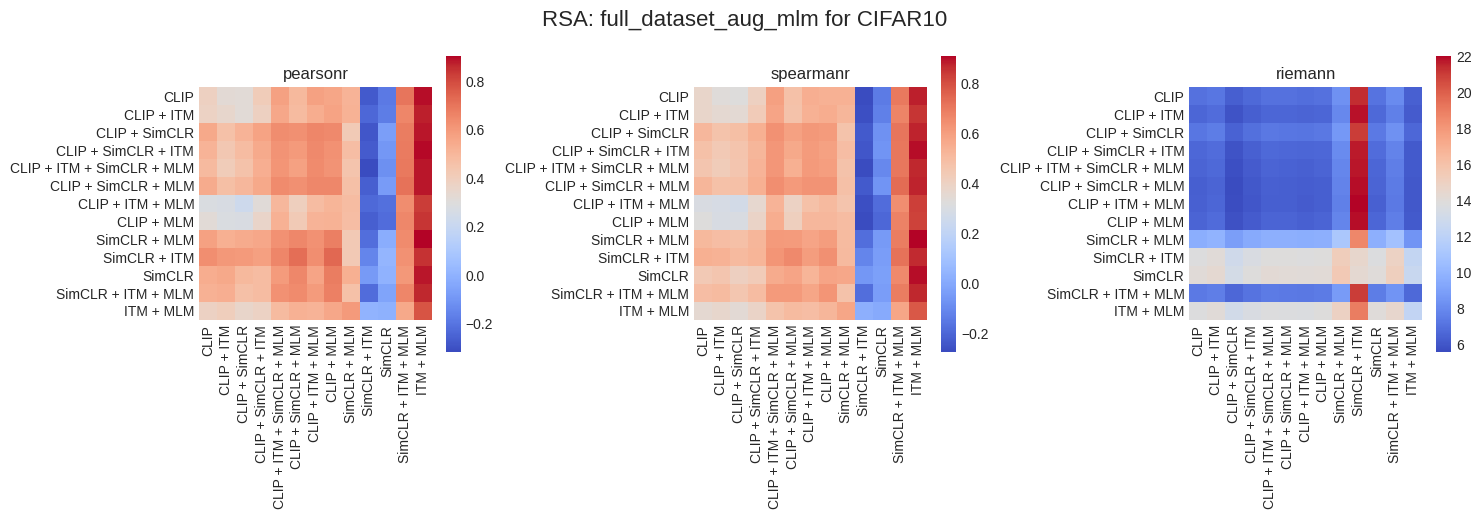

In [15]:
plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(15, 5))
plt.suptitle(f"RSA: {checkpoints} for {dataset_name}", fontsize=16)

for sind, sim in enumerate(similarity_measure):
    plt.subplot(1, 3, sind + 1)
    plt.title(sim)
    rsa_matrix = get_rsa_matrix(mean_class_representations_img, mean_class_representations_txt, rsa_similarity_measure=sim, rdm_similarity_measure="cosine")
    plt.imshow(rsa_matrix, cmap="coolwarm")
    plt.yticks(
        [x for x in range(len(mean_class_representations_img.keys()))], 
        [cfg_checkpoints[k]["model"] for k in mean_class_representations_img.keys()],
    )
    plt.xticks(
        [x for x in range(len(mean_class_representations_img.keys()))],
        [cfg_checkpoints[k]["model"] for k in mean_class_representations_img.keys()],
        rotation=90,
    )
    plt.colorbar()#fraction=0.045)

plt.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_FIGURES_DIR, f"RSA-{DATASET_SPLIT}.png"), bbox_inches="tight"
# )

Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rs

/tmp/ipykernel_535556/3173755742.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  z = hierarchy.linkage(rsa_matrix)


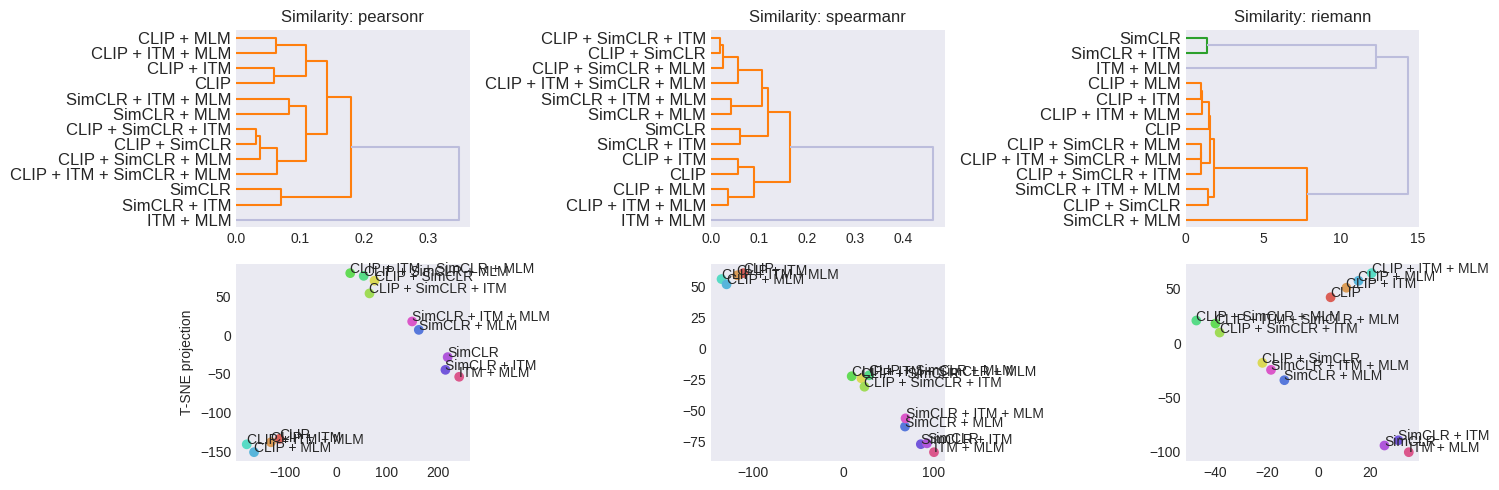

In [ ]:
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.manifold import TSNE

plt.style.use("seaborn-v0_8-dark")

labels = [cfg_checkpoints[k]["model"] for k in mean_class_representations.keys()]
fig, axes = plt.subplots(2, 3, figsize=(15, 5), height_ratios=[1, 1])

axes[1, 0].set_ylabel("T-SNE projection")

for sind, sim in enumerate(similarity_measure):
    rsa_matrix = get_rsa_matrix(mean_class_representations, rsa_similarity_measure=sim)
    z = hierarchy.linkage(rsa_matrix)
    dn2 = hierarchy.dendrogram(
        z,
        ax=axes[0, sind],
        above_threshold_color="#bcbddc",
        # color_threshold=1.5,
        orientation="right",
        labels=labels,
    )
    axes[0, sind].set_title(f"Similarity: {sim}")

    _perplexity = 2
    X_embedded = TSNE(
        n_components=2, learning_rate="auto", init="random", perplexity=_perplexity
    ).fit_transform(rsa_matrix)

    xs = X_embedded[:, 0]
    ys = X_embedded[:, 1]
    axes[1, sind].scatter(
        xs,
        ys,
        color=sns.color_palette("hls", 13),
    )

    xoffset = 0
    yoffset = 0
    for ind, labeltext in enumerate(labels):
        axes[1, sind].text(xs[ind] + xoffset, ys[ind] + yoffset, labeltext, rotation=0)

fig.tight_layout()
# plt.savefig(
#     os.path.join(SAVE_FIGURES_DIR, f"RSA-tsne_dendrogram-{DATASET_SPLIT}.png"),
#     bbox_inches="tight",
# )